In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

# For pipeline
from tqdm import tqdm

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/longjiaoli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/longjiaoli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/longjiaoli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/longjiaoli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load data and merge texts

In [18]:
df = pd.read_csv("emscad_v1.csv")
df.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f


In [4]:
# Data cleaning functions
def clean_text(text):
    # Remove content inside '< >' symbols
    text = re.sub('<.*?>', '', text)
    
    # Remove links starting with 'http'
    text = re.sub(r'http\S+', '', text)
    
    # Remove newline characters, carriage return characters, and tab characters
    text = re.sub(r'[\n\r\t]', ' ', text)
    
    return text

def clean_data(data):
    #Change all boolean variables to binary representations.
    data['fraudulent'] = np.where(data['fraudulent']=='t', 1, 0)
    
    #clean the texts
    data['company_profile'] = data['company_profile'].apply(lambda x: clean_text(str(x)))
    data['description'] = data['description'].apply(lambda x: clean_text(str(x)))
    data['benefits'] = data['benefits'].apply(lambda x: clean_text(str(x)))
    data['requirements'] = data['requirements'].apply(lambda x: clean_text(str(x)))
    
    return data


In [19]:
clean_data(df)
df.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a...,nan,f,t,f,Other,Internship,NaN,NaN,Marketing,0,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you: Your key responsibil...,What you will get from us Through being part ...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions ...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissionin...,nan,f,t,f,NaN,NaN,NaN,NaN,NaN,0,f


In [20]:
df['description'].iloc[1]

"Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0  We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!  We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa0  90 Seconds, the worlds Cloud Video Production Service -\xa0  9

In [21]:
# Merge compnany profile, description, requirements, and benefits into a document
def merge_text(row):
    company_profile = row['company_profile']
    description = row['description']
    requirements = row['requirements']
    benefits = row['benefits']
    
    text = ""
    if not pd.isnull(company_profile):
        text += "Company profile: " + company_profile + ". "
    if not pd.isnull(description):
        text += "Description: " + description + ". "
    if not pd.isnull(requirements):
        text += "Requirements: " + requirements + ". "
    if not pd.isnull(benefits):
        text += "Benefits: " + benefits + ". "
        
    return text

df['text'] = df.apply(merge_text, axis=1)
df.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,text
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a...,nan,f,t,f,Other,Internship,NaN,NaN,Marketing,0,f,"Company profile: We're Food52, and we've creat..."
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you: Your key responsibil...,What you will get from us Through being part ...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,f,"Company profile: 90 Seconds, the worlds Cloud ..."
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions ...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissionin...,nan,f,t,f,NaN,NaN,NaN,NaN,NaN,0,f,Company profile: Valor Services provides Wor...


In [22]:
# Merge compnany profile, description, requirements, and benefits into a document
def merge_jd(row):
    description = row['description']
    requirements = row['requirements']
    
    text = ""
    if not pd.isnull(description):
        text += description
    else:
        text += 'NaNDescription'
        
    if not pd.isnull(requirements):
        text += requirements
    else:
        text += 'NaNRequirements'
    return text

df['jd'] = df.apply(merge_jd, axis=1)
df.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,text,jd
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a...,nan,f,t,f,Other,Internship,NaN,NaN,Marketing,0,f,"Company profile: We're Food52, and we've creat...","Food52, a fast-growing, James Beard Award-winn..."
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you: Your key responsibil...,What you will get from us Through being part ...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,f,"Company profile: 90 Seconds, the worlds Cloud ...",Organised - Focused - Vibrant - Awesome!Do you...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions ...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissionin...,nan,f,t,f,NaN,NaN,NaN,NaN,NaN,0,f,Company profile: Valor Services provides Wor...,"Our client, located in Houston, is actively se..."


In [271]:
df['jd'].iloc[10]

"<p><br><br>Position : #URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd# Developer<br>Job Location :United States-New Jersey-Jersey City<br>Us work status required : EAD / Green Card / US Citizens <br><br>Detailed Description<br><br>#URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd# Developer with strong SQL &amp; VB.NET working in a highly effective software development team responsible for development of and enhancements to our IDB reporting and billing systems. All work efforts will be performed according to policies and procedures relating to software development and quality.<br>Background: <br>Developer with 5+ years of development experience using #URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd#, VB.NET, including 3-5 years in SQL development.<br><br>Required:<br><br>• College degree<br>• Experience building web based applications using #URL_86fd830a95a64e2b30ceed829e63fd384c289e4f01e3c93608b42a84f6e662dd# and SQL Ser

# Preprocess
preprocess all data, including the training and testing set

In [23]:
# remove line breaks
def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_html_symbols(text):
    clean_text = re.sub('<[^<]+?>', '', text)
    return clean_text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # we look later which patterns to escape
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers: word_tokenize('ebrahim^hazrati')'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

#remove one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   

special_words_list=['url','amp','job','company',"en","van" ,"de" ,"een","je","het","met"] # here we can decide a list of special words that is not useful in our analysis but is not removed by stopwords

##remove specific word list
def remove_special_words(text):
    '''Remove the User predefine useless words from the text. The list should be in the lowercase.'''
# list : words
    querywords=text.split()
    textwords = [word for word in querywords if word.lower() not in special_words_list]
    text=' '.join(textwords)
    return text


# Stemming with 'Snowball English stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ''.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens

#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    


def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)

def remove_require_words(text):
    clean_text = re.sub(r'\b(require\w*)\b', '', text)
    return clean_text

def remove_describe_words(text):
    clean_text = re.sub(r'\b(descri\w*)\b', '', text)
    return clean_text

In [24]:
## Pipeline Version 1
def pipe_line_vers1(text):
    _steps = [   # Here we. can decide the steps and which functions we want to use for our data cleaning
    remove_line_breaks,
    remove_html_symbols,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    lemma,
    remove_one_character_words,
    remove_numbers,
    remove_special_words,
    remove_require_words,
    remove_describe_words]
    
    for step in _steps:
        text=step(str(text))  #convert to string
    return text

In [25]:
wordbag_jd = []
for i in tqdm(df['jd']):
    wordbag_jd.append(pipe_line_vers1(i)) 
df['wordbag_jd'] = pd.Series(wordbag_jd)

100%|████████████████████████████████████| 17880/17880 [00:59<00:00, 300.43it/s]


# LDA

In [26]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import gensim

def obtain_lda_model(texts_list, n_topics, alpha = 'auto'):
    """
        Input: texts_list of format [[sent_1], ..., [sent_n]] where for each sent_i = [word_1, ..., word_n]
        Output: LDA model (gensim model)
        Function: Create a dictonary object that is used to create an LDA model.
    """
    dictionary = Dictionary(texts_list) # Construct word <-> id mappings used by the LDA model
    # Filter words that occur in less than 15 the documents (no_above)
    # Filter words that occur in more than 50% of the provided documents
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)  
    common_corpus = [dictionary.doc2bow(text) for text in texts_list]
    _ = dictionary[0] # need this line to force-load the data in the kernel
    id2word = dictionary.id2token
    
    # For further reading on the documentation of the LdaModel please see: https://radimrehurek.com/gensim/models/ldamodel.html
    lda = LdaModel(common_corpus, id2word=id2word,num_topics=n_topics, decay = 0.6, minimum_probability=0.01, alpha = alpha)
    return [lda,common_corpus,dictionary]



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


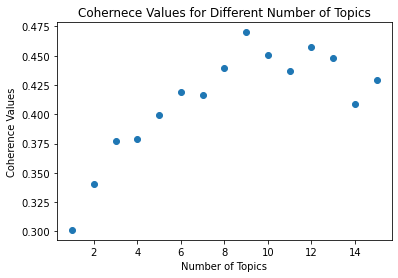

In [70]:
# choose the number of topics based on the coherence score
from gensim.models import CoherenceModel

# Initialize an empty list to store perplexity scores
coherence_values = []
topic_nums = [i+1 for i in range(15)]

texts_list = [[word for word in document.split()] for document in df['wordbag_jd'].tolist()]

# Train topic models and calculate perplexity for each number of topics
for num_topics in topic_nums:
    [lda, corpus, id2word] = obtain_lda_model(texts_list, num_topics, alpha = 'auto')
    coherence_model_lda = CoherenceModel(model=lda, texts=texts_list, dictionary=id2word, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    coherence_values.append(coherence)
    print(num_topics)

# Plot the perplexity scores
plt.scatter(topic_nums, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Values")
plt.title("Cohernece Values for Different Number of Topics")
plt.show()

In [72]:
n_topics = 11
texts_list = [[word for word in document.split()] for document in df['wordbag_jd'].tolist()]
[lda_jd, corpus, id2word] = obtain_lda_model(texts_list,n_topics)

lda_jd.print_topics()

[(0,
  '0.022*"marketing" + 0.013*"medium" + 0.011*"social" + 0.009*"content" + 0.008*"digital" + 0.008*"campaign" + 0.007*"creative" + 0.007*"brand" + 0.006*"new" + 0.006*"communication"'),
 (1,
  '0.017*"project" + 0.010*"process" + 0.010*"management" + 0.010*"customer" + 0.010*"ability" + 0.008*"ensure" + 0.008*"quality" + 0.008*"product" + 0.007*"manager" + 0.006*"environment"'),
 (2,
  '0.017*"system" + 0.010*"knowledge" + 0.009*"service" + 0.009*"ability" + 0.009*"support" + 0.009*"technical" + 0.008*"software" + 0.007*"test" + 0.007*"management" + 0.007*"customer"'),
 (3,
  '0.022*"customer" + 0.017*"service" + 0.017*"ability" + 0.011*"perform" + 0.010*"mail" + 0.010*"environment" + 0.008*"assigned" + 0.007*"high" + 0.007*"task" + 0.007*"preferred"'),
 (4,
  '0.009*"service" + 0.008*"patient" + 0.008*"must" + 0.007*"care" + 0.007*"ability" + 0.007*"office" + 0.006*"provide" + 0.006*"client" + 0.006*"support" + 0.006*"position"'),
 (5,
  '0.014*"design" + 0.012*"development" + 0.

In [92]:
import csv
# Save the list to a CSV file
with open("corpus.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(corpus)

In [73]:
lda_jd.save('lda.model')

In [94]:
def topic_matrix(lda,corpus,n_topics):
    col = [str(i) for i in range(n_topics)]
    df = pd.DataFrame(columns=col, index=range(len(corpus)))
    i = 0
    for doc in corpus:
        for topic_num, prob in lda.get_document_topics(doc):
            df.iloc[i,topic_num] = prob
        i += 1        
    df = df.fillna(0)
    
    return df

df_lda_jd = topic_matrix(lda_jd,corpus,n_topics)
display(df_lda_jd)
df_lda_jd.to_csv('df_lda.csv')

,0,1,2,3,4,5,6,7,8,9,10
0,0.843240,0.000000,0.000000,0.0,0.129313,0.023743,0.000000,0.000000,0.000000,0.0,0.000000
1,0.461015,0.000000,0.238566,0.0,0.000000,0.038640,0.000000,0.260180,0.000000,0.0,0.000000
2,0.000000,0.390031,0.086231,0.0,0.019531,0.000000,0.000000,0.000000,0.500167,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.997938
4,0.000000,0.531466,0.000000,0.0,0.464855,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
17875,0.000000,0.000000,0.000000,0.0,0.000000,0.520710,0.000000,0.000000,0.000000,0.0,0.476453
17876,0.000000,0.118918,0.000000,0.0,0.820428,0.057140,0.000000,0.000000,0.000000,0.0,0.000000
17877,0.000000,0.854610,0.000000,0.0,0.000000,0.000000,0.142097,0.000000,0.000000,0.0,0.000000
17878,0.448880,0.000000,0.000000,0.0,0.000000,0.543173,0.000000,0.000000,0.000000,0.0,0.000000


# Test training set split

In [75]:
# combine lda matrix with other engineered features
df_selected = pd.read_csv('selected_data.csv')
df_all = pd.concat([df_selected,df_lda_jd],axis = 1)

In [76]:
from sklearn.preprocessing import StandardScaler

#  Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to your DataFrame
scaler.fit(df_all.drop('fraudulent',axis = 1).values)
X_scaled = scaler.transform(df_all.drop('fraudulent',axis = 1).values)
df_scaled = pd.DataFrame(X_scaled,columns = df_all.drop('fraudulent',axis = 1).columns)
df_scaled['fraudulent'] = df_all['fraudulent'].values

In [84]:
np.random.seed(26)
# Train_test
df_train = df_all.sample(frac = 0.75)
df_test = df_all.drop(df_train.index)

df_train['fraudulent'].value_counts()

fraudulent
0    12748
1      662
Name: count, dtype: int64

In [85]:
# oversample the training set to tackle the imbalance
def over_sample(data):
    #Make a balanced dataset by oversampling
    data_Fraud = data[data['fraudulent']==1]
    data_NonFraud =  data[data['fraudulent']==0]    
    df_fraud_example = pd.concat([data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                  data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                  data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                 data_Fraud, data_Fraud, data_Fraud, data_Fraud, 
                                 data_Fraud, data_Fraud, data_Fraud], axis = 0)
    data_balanced = pd.concat([data_NonFraud, df_fraud_example], axis = 0)
    data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)
    return data_balanced

df_train_bal = over_sample(df_train)
df_train_bal['fraudulent'].value_counts()

fraudulent
0    12748
1    12578
Name: count, dtype: int64

In [86]:
X_train = df_train_bal.drop(['fraudulent'], axis=1).values
y_train = df_train_bal['fraudulent'].values

X_test = df_test.drop(['fraudulent'], axis=1).values
y_test = df_test['fraudulent'].values

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


## Logistic Regression

Accuracy (overall correct predictions): 0.81
Auc: 0.89
Recall (all 1s predicted right): 0.78
Precision (confidence when predicting a 1): 0.82
Detail:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     12748
           1       0.82      0.78      0.80     12578

    accuracy                           0.81     25326
   macro avg       0.81      0.81      0.81     25326
weighted avg       0.81      0.81      0.81     25326

Accuracy (overall correct predictions): 0.83
Auc: 0.87
Recall (all 1s predicted right): 0.77
Precision (confidence when predicting a 1): 0.18
Detail:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      4266
           1       0.18      0.77      0.29       204

    accuracy                           0.83      4470
   macro avg       0.58      0.80      0.60      4470
weighted avg       0.95      0.83      0.87      4470



/Users/longjiaoli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


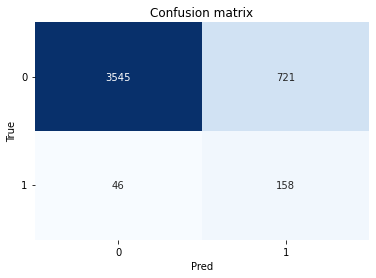

In [87]:
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# fit model
model.fit(X_train, y_train)

#train set prediction
predicted_prob = model.predict_proba(X_train)[:,1]
predicted = model.predict(X_train)
## Accuray e AUC
accuracy = metrics.accuracy_score(y_train, predicted)
auc = metrics.roc_auc_score(y_train, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
## Precision e Recall
recall = metrics.recall_score(y_train, predicted)
precision = metrics.precision_score(y_train, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_train, predicted, target_names=[str(i) for i in np.unique(y_test)]))

#test set prediction
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

In [81]:
model.coef_

array([[ 5.21916295e-03, -3.56116528e-04, -2.58635302e-03,
         3.03437248e-03,  4.70354690e-01, -1.03623380e+00,
        -1.82200621e-01,  1.48166984e+00,  3.80778773e-01,
         2.18198733e-01,  3.70414455e-02,  8.97750068e-01,
         2.16750300e+00, -6.39385613e-01, -1.72478651e+00,
         3.06518854e+00,  4.10368292e-01, -1.17955535e+00,
         8.25870635e-01, -2.06118861e+00, -1.09269330e+00,
         1.15650563e+00,  2.05991292e+00, -1.76608763e+00,
        -5.48074937e-01]])

# Random forest

Accuracy (overall correct predictions): 0.98
Auc: 0.98
Recall (all 1s predicted right): 0.59
Precision (confidence when predicting a 1): 0.87
Detail:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4266
           1       0.87      0.59      0.70       204

    accuracy                           0.98      4470
   macro avg       0.93      0.79      0.84      4470
weighted avg       0.98      0.98      0.98      4470



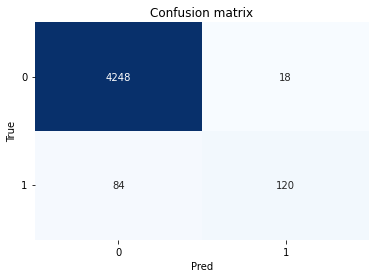

In [88]:
from sklearn.ensemble import RandomForestClassifier
## call model
rf = RandomForestClassifier(n_estimators = 50, random_state = 26)
# fit model
rf.fit(X_train, y_train)

predicted_prob = rf.predict_proba(X_test)[:,1]
rf_predicted = rf.predict(X_test)

## Accuray and AUC
accuracy = metrics.accuracy_score(y_test, rf_predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision and Recall
recall = metrics.recall_score(y_test, rf_predicted)
precision = metrics.precision_score(y_test, rf_predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, rf_predicted, target_names=[str(i) for i in np.unique(y_test)]))

import seaborn as sns

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, rf_predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

## Boosted gradient descent

Accuracy (overall correct predictions): 1.0
Auc: 1.0
Recall (all 1s predicted right): 1.0
Precision (confidence when predicting a 1): 1.0
Detail:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12748
           1       1.00      1.00      1.00     12578

    accuracy                           1.00     25326
   macro avg       1.00      1.00      1.00     25326
weighted avg       1.00      1.00      1.00     25326

Accuracy (overall correct predictions): 0.97
Auc: 0.97
Recall (all 1s predicted right): 0.75
Precision (confidence when predicting a 1): 0.7
Detail:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4266
           1       0.70      0.75      0.72       204

    accuracy                           0.97      4470
   macro avg       0.84      0.87      0.85      4470
weighted avg       0.97      0.97      0.97      4470



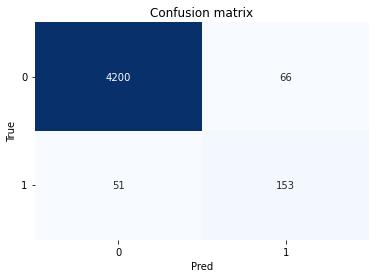

In [89]:
## call model
GB = ensemble.GradientBoostingClassifier(max_depth=10, random_state=26)
GB.fit(X_train, y_train)

#train set prediction
predicted_prob = GB.predict_proba(X_train)[:,1]
predicted = GB.predict(X_train)
## Accuray e AUC
accuracy = metrics.accuracy_score(y_train, predicted)
auc = metrics.roc_auc_score(y_train, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
## Precision e Recall
recall = metrics.recall_score(y_train, predicted)
precision = metrics.precision_score(y_train, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_train, predicted, target_names=[str(i) for i in np.unique(y_test)]))

#test set prediction
predicted_prob = GB.predict_proba(X_test)[:,1]
predicted = GB.predict(X_test)
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()